In [1]:
from random import random, sample

In [2]:
sample_rate = .25
sr_str = str(int(sample_rate*100))

In [3]:
f = open('data/string_nonzero_experiments.csv')
num_links=0
for line in f:
    num_links+=1
print(num_links)

f = open('data/string_nonzero_experiments.csv')
proteins = set()
pairs = set()
uniq_pair_file = open('data/unique_string_nonzero_experiments.csv','w')
uniq_protein_file = open('data/unique_experiment_protein_ids.csv','w')

next(f)
for line in f:
    source, target, score = line.strip().split(',')
    
    if source not in proteins:
        uniq_protein_file.write(source + '\n')
    proteins.add(source)
    
    if target not in proteins:
        uniq_protein_file.write(target + '\n')
    proteins.add(target)
    
    if (source,target) not in pairs:
        uniq_pair_file.write(line)
    pairs.add((source,target))

print(len(proteins))
print(len(pairs))
uniq_pair_file.close()
uniq_protein_file.close()

f = open('data/string_nonzero_experiments.csv')

train_file = open('data/protein_pairs/train_split_' + sr_str + '.dat','w')
test_file = open('data/protein_pairs/test_split_' + sr_str + '.dat','w')
validation_file = open('data/protein_pairs/validation_split_' + sr_str + '.dat','w')
train_neg_file = open('data/protein_pairs/train_neg_split_' + sr_str + '.dat','w')
test_neg_file = open('data/protein_pairs/test_neg_split_' + sr_str + '.dat','w')
validation_neg_file = open('data/protein_pairs/validation_neg_split_' + sr_str + '.dat','w')

header = next(f)
train_file.write(header)
test_file.write(header)
validation_file.write(header)

for line in f:
    r = random()
    negative = tuple(sample(proteins, 2))
    while negative in pairs:
        negative = tuple(sample(proteins, 2))
    # Training set size determined by sampling rate
    if r >= sample_rate:
        train_file.write(line)
        train_neg_file.write(','.join(negative) + ',0\n')
    else:
        # Split non-training data into test/validation equally
        r = random()
        if r >= .5:
            test_file.write(line)
            test_neg_file.write(','.join(negative) + ',0\n')
        else:
            validation_file.write(line)
            validation_neg_file.write(','.join(negative) + ',0\n')


train_file.close()
test_file.close()
validation_file.close()
train_neg_file.close()
test_neg_file.close()
validation_neg_file.close()
f.close()

357945
14795
349276


In [4]:
import gensim
from node2vec import Node2Vec

C:\dev\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
import keras
import tensorflow as tf
import numpy as np

C:\dev\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
class Sequences:
    def __init__(self, filename):
        self.filename = filename
        self.f = open(self.filename)
    
    # this function is called each epoch of gensim training
    def __iter__(self):
        self.f = open(self.filename)
        return self
    
    def __next__(self):
        line = next(self.f)
        id,sequence = line.strip().split(',')
        sequence = sequence.split(' ')
        return gensim.models.doc2vec.TaggedDocument(tags=[id], words=sequence)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [8]:
from sklearn.metrics import classification_report, precision_recall_curve, precision_score, recall_score, accuracy_score, f1_score

In [9]:
from sklearn.utils.fixes import signature
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score

In [10]:
d2v_epochs = 21
d2v_vector_size = 99
d2v_window = 8
d2v_min_count = 9
n2v_dimensions = 104
n2v_window = 6
n2v_epochs = 30
n2v_num_walks = 32
n2v_walk_length = 27
n2v_p = 4
n2v_q = 2
nn_dropout = 0.22818154872598262

In [11]:
training_edgelist_file = 'data/protein_pairs/train_split_' + sr_str + '.dat'

print('Training Node2Vec'.center(80,'-'))
n2v = Node2Vec()
model = n2v.fit_transform(training_edgelist_file,
                          dimensions=n2v_dimensions, 
                          window=n2v_window,
                          epochs=n2v_epochs,
                          num_walks=n2v_num_walks, 
                          walk_length=n2v_walk_length, 
                          p=n2v_p, 
                          q=n2v_q,
                         )

n2v.model.save('models/node2vec.model')

# vectorfilename = 'data/vectors/node2vec_sample{}_p{}_q{}.dat'.format(sr_str, p, q)
# vector_file = open(vectorfilename, 'w')
# for i,n in enumerate(n2v.G.nodes):
#     vector_file.write(n + ',' + ','.join([str(_) for _ in model.wv.vectors[i,:]]) + '\n')
# vector_file.close()

print('Node2Vec similarity to BRCA1'.center(80,'-'))
for v in n2v.model.wv.most_similar('P38398|BRCA1_HUMAN'):
    print(v)

#### doc2vec

filename = 'data/split_human_uniprot_sequences.dat'
sequences = Sequences(filename)
print('Training doc2vec'.center(80,'-'))

doc2vec = gensim.models.Doc2Vec(
    documents=sequences,
    epochs=d2v_epochs,
    dm=1,
    vector_size=d2v_vector_size,
    window=d2v_window,
    min_count=d2v_min_count
)

doc2vec.save('models/doc2vec.model')

print('Doc2Vec similarity to BRCA1'.center(80,'-'))
for v in doc2vec.docvecs.most_similar(positive=['P38398|BRCA1_HUMAN']):
    print(v)

unmatched_doc2vec_node2vec_proteins_file = open('data/unmatched_doc2vec_node2vec_proteins_file.csv','w')
i=0
vectors = dict()
for protein in n2v.model.wv.index2word:
#     print(protein)
    try:
        v = np.append(
            doc2vec[protein],
            n2v.model.wv[protein]
        )
        vectors[protein] = v
        i+=1
    except:
        unmatched_doc2vec_node2vec_proteins_file.write(protein + '\n')

unmatched_doc2vec_node2vec_proteins_file.close()
#     print(i)

print('Generating Training and validation datasets'.center(80,'-'))

train_file = open('data/protein_pairs/train_split_' + sr_str + '.dat')
header = next(train_file)
x_train = []
y_train = []

for line in train_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_train.append(np.append(vs,vt))
        y_train.append(np.array([1]))

train_neg_file = open('data/protein_pairs/train_neg_split_' + sr_str + '.dat')
header = next(train_neg_file)

for line in train_neg_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_train.append(np.append(vs,vt))
        y_train.append(np.array([0]))

x_train = np.array(x_train)
y_train = np.array(y_train)

print('Training data shape')
print('x',x_train.shape)
print('y',y_train.shape)

validation_file = open('data/protein_pairs/validation_split_' + sr_str + '.dat')
header = next(validation_file)
x_validation = []
y_validation = []

for line in validation_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_validation.append(np.append(vs,vt))
#             y_validation.append(np.array([1,0]))
        y_validation.append(np.array([1]))
        i+=1

validation_neg_file = open('data/protein_pairs/validation_neg_split_' + sr_str + '.dat')
header = next(validation_neg_file)

for line in validation_neg_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_validation.append(np.append(vs,vt))
#             y_validation.append(np.array([0,1]))
        y_validation.append(np.array([0]))
        i+=1

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

print(x_validation.shape)
print(y_validation.shape)

-------------------------------Training Node2Vec--------------------------------
Walk iteration: 
1 / 32
num walks 14688
2 / 32
num walks 29376
3 / 32
num walks 44064
4 / 32
num walks 58752
5 / 32
num walks 73440
6 / 32
num walks 88128
7 / 32
num walks 102816
8 / 32
num walks 117504
9 / 32
num walks 132192
10 / 32
num walks 146880
11 / 32
num walks 161568
12 / 32
num walks 176256
13 / 32
num walks 190944
14 / 32
num walks 205632
15 / 32
num walks 220320
16 / 32
num walks 235008
17 / 32
num walks 249696
18 / 32
num walks 264384
19 / 32
num walks 279072
20 / 32
num walks 293760
21 / 32
num walks 308448
22 / 32
num walks 323136
23 / 32
num walks 337824
24 / 32
num walks 352512
25 / 32
num walks 367200
26 / 32
num walks 381888
27 / 32
num walks 396576
28 / 32
num walks 411264
29 / 32
num walks 425952
30 / 32
num walks 440640
31 / 32
num walks 455328
32 / 32
num walks 470016
--------------------------Node2Vec similarity to BRCA1--------------------------
('Q99728|BARD1_HUMAN', 0.73031777143

C:\dev\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


--------------------------Doc2Vec similarity to BRCA1---------------------------
('Q9BR77|CCD77_HUMAN', 0.6820972561836243)
('Q9HCI6|K1586_HUMAN', 0.666049063205719)
('Q8NA77|TEX19_HUMAN', 0.6482510566711426)
('P51587|BRCA2_HUMAN', 0.6255503296852112)
('Q86WC4|OSTM1_HUMAN', 0.6236699223518372)
('O60268|K0513_HUMAN', 0.6206947565078735)
('Q9HBT8|Z286A_HUMAN', 0.6156860589981079)
('Q5JR59|MTUS2_HUMAN', 0.6134325265884399)
('Q69YH5|CDCA2_HUMAN', 0.6126266717910767)
('Q7Z4S6|KI21A_HUMAN', 0.6122199892997742)
------------------Generating Training and validation datasets-------------------
Training data shape
x (509879, 406)
y (509879, 1)
(85542, 406)
(85542, 1)


#### Generating test data

In [ ]:
print('Training Neural Network'.center(80,'-'))

model = Sequential()

input_size = (d2v_vector_size + n2v_dimensions)*2

model.add(Dense(units=256, activation='relu', input_dim=input_size))
model.add(Dropout(nn_dropout))
model.add(Dense(units=128, activation='relu', input_dim=256))
model.add(Dropout(nn_dropout))
model.add(Dense(units=64, activation='relu', input_dim=128))
model.add(Dropout(nn_dropout))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])

# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(x_train, y_train, epochs=10, batch_size=32)

training_accuracy = model.evaluate(x_train, y_train, batch_size=128)
validation_accuracy = model.evaluate(x_validation, y_validation, batch_size=128)
print('Training accuracy: ')
print(training_accuracy)

In [22]:
test_file = open('data/protein_pairs/test_split_' + sr_str + '.dat')
header = next(test_file)
x_test = []
y_test = []

for line in test_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_test.append(np.append(vs,vt))
#             y_test.append(np.array([1,0]))
        y_test.append(np.array([1]))
        i+=1

test_neg_file = open('data/protein_pairs/test_neg_split_' + sr_str + '.dat')
header = next(test_neg_file)

for line in test_neg_file:
    source, target, score = line.strip().split(',')
    if source in vectors and target in vectors:
        vs = vectors[source]
        vt = vectors[target]
        x_test.append(np.append(vs,vt))
#             y_test.append(np.array([0,1]))
        y_test.append(np.array([0]))
        i+=1

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(84870, 406)
(84870, 1)


### Validation

In [ ]:
validation_accuracy = model.evaluate(x_validation, y_validation, batch_size=128)
print('Validation accuracy: {}')
print(validation_accuracy)

# model.train_on_batch(x_batch, y_batch)

y_validation_pred = model.predict_proba(x=x_validation)

average_precision = average_precision_score(y_true=y_validation, y_score=y_validation_pred)

Average precision-recall score: 0.97087


Text(0.5,1,'2-class Precision-Recall curve: AP=0.97087')

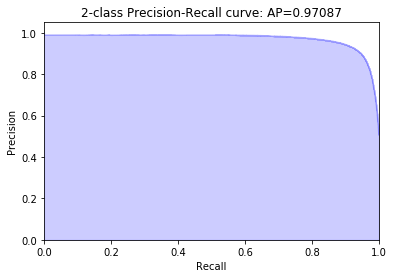

In [25]:
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true=y_validation, probas_pred=y_validation_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(average_precision))

Text(0.5,1,'2-class ROC curve: AP=0.97163')

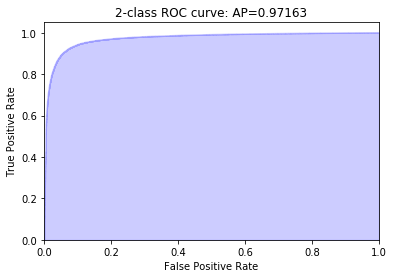

In [26]:
fpr, tpr, _ = roc_curve(y_true=y_validation, y_score=y_validation_pred)
auroc = roc_auc_score(y_true=y_validation, y_score=y_validation_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class ROC curve: AP={0:0.5f}'.format(auroc))

### Test

In [28]:
test_accuracy = model.evaluate(x_test, y_test, batch_size=128)
print('Validation accuracy: {}')
print(test_accuracy)

# model.train_on_batch(x_batch, y_batch)

y_test_pred = model.predict_proba(x=x_test)

average_precision = average_precision_score(y_true=y_test, y_score=y_test_pred)

84870/84870 [==============================] - 2s 21us/step
Validation accuracy: {}
[0.29858811526965645, 0.9209496877577471]


In [ ]:
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_test_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.5f}'.format(average_precision))

Text(0.5,1,'2-class ROC curve: AP=0.97196')

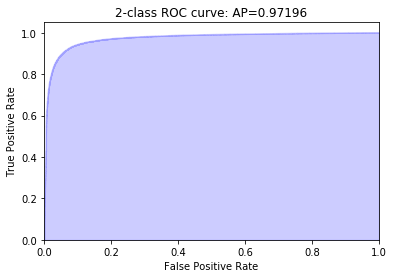

In [31]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_test_pred)
auroc = roc_auc_score(y_true=y_test, y_score=y_test_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class ROC curve: AP={0:0.5f}'.format(auroc))